In [1]:
from etc.init import *
import etc.figureslib as lib

import NotebookScripter
from NotebookScripter import run_notebook, receive_parameter
NotebookScripter.set_notebook_option(with_matplotlib_backend=None)
savefig = receive_parameter(savefig=False)
saveext = receive_parameter(saveext='pdf')
try:
    data
except NameError:
    data = receive_parameter(data=None)

if data is None:
    data = run_notebook("Figures_load_data.ipynb")
records = data.records

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
[monochrome_palette]: value was greater than 1 and was clipped.



import copy
import os.path
import itertools
from collections import Iterable, OrderedDict, namedtuple, deque
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image
from matplotlib.gridspec import GridSpec
import pymc3 as pymc
import pandas as pd
from pandas import DataFrame
from parameters import ParameterSet

from importlib import reload

import theano_shim as shim

import mackelab as ml
import mackelab.smttk as smttk
import mackelab.iotools
import mackelab.pymc3
import mackelab.parameters
import mackelab.plot
ml.parameters.Transform.namespaces['shim'] = shim

import sinn
import sinn.histories as histories
import sinn.models
from sinn.optimize.gradient_descent import FitCollection
import sinn.analyze as anlz
from sinn.analyze.axisdata import LogLikelihood, Likelihood, Probability
from sinn.analyze.axis import Axis

import fsGIF.core as core
import fsGIF.fsgif_model as fsgif_model
from fsGIF.fsgif_model

In [2]:
import re

In [3]:
mplconfig = run_notebook("Figures_matplotlib_config.ipynb")
inject_vars(mplconfig, globals())

|subset | Parameters |
|-|:---------:|
|$η^1$ | $w$ |
|$η^3$ | $J_{θ,E}$, $τ_{θ,E}$ |
|$η^5$ | all ($w$, $τ_m$, $c$, $τ_s$, $Δu$, <br> $J_{θ,E}$, $τ_{θ,E}$) |

In [4]:
outputname = "Fig4"

In [5]:
varstrings = lib.varstrings

In [6]:
param_subsets = odict[
    'η1' : {'w': [0, 1, 2, 3]},
    'η2' : {'J_θ': [0], 'τ_θ': [0]},
]
param_subsets['η3'] = {**param_subsets['η1'], **param_subsets['η2'], **{'c': [0, 1], 'Δu': [0, 1], 'τ_s': [0, 1], 'τ_m': [0,1]}}

def get_varname(η, varidx, idx=None):
    if idx is None: varname = varidx[0]; idx=varidx[1]
    else: varname = varidx
    return varnames[varname][param_subsets[η][varname][idx]]

In [7]:
records.filter.script('gradient').summary.head(10)

,# records,reason,outcome,tags,main_file,avg . duration
20200302-021305,8,sgd_test_R,,,../code/fsGIF/gradient_descent.py,5h 22m 15s
20200229-013019,20,sgd_test_cstI,,,../code/fsGIF/gradient_descent.py,5h 09m 27s
20200227-202456,19,sgd_test_unclamped_ur,,,../code/fsGIF/gradient_descent.py,5h 19m 22s
20190724-211644,24,sgd_only-adapt_L:9,,,../code/fsGIF/gradient_descent.py,5h 14m 13s
20190612-125539,510,More_4_pop_fits_because_plots_are_not_good_enough,,,../code/fsGIF/gradient_descent.py,9h 03m 11s
20181113-091205,82,sgd_4pop_100-more-fits,,,fsGIF/fsGIF/gradient_descent.py,9h 15m 36s
20181107-110946,30,sgd_4pop_wider-w-prior,,,fsGIF/fsGIF/gradient_descent.py,9h 08m 58s
20181030-164336,21,sgd_sine-wn_4pop,,,fsGIF/fsGIF/gradient_descent.py,16h 16m 22s
20181030-155623,7,sgd_sine-wn_4pop,,,fsGIF/fsGIF/gradient_descent.py,0h 25m 53s
20181022-155600,41,sgd-hetero_sin-wn_fit-all,,,fsGIF/fsGIF/gradient_descent.py,5h 09m 51s


In [8]:
fitlabels = {}
fitlabels['η1'] = {'20180924-180753', '20180928-180308', '20181001-164931', '20181003-094813'}
fitlabels['η2'] = {'20181007-230106', '20190724-211644'}
fitlabels['η3'] = {'20181015-131341', '0180922-143526'}
datalens = [1.25, 2., 3., 5., 7., 9.]

In [9]:
fitrecords = {}
for key, lbls in fitlabels.items():
    _fitrecords = lib.RecordSet(lbls)
    fitrecords[key] = {L: lib.RecordSet(_fitrecords
                                        .filter.parameters.posterior.datalen(L)
                                        .list)
                       for L in datalens}

    for key, lbls in fitlabels.items():
        for L in datalens:
            recs = (records.filter.any.label(lbls)
                           .filter.parameters.posterior.datalen(L)
                           .list)
            print(key, L, len(recs),
                  recs.latest.parameters.posterior.mask.w if len(recs) > 0 else "")

When creating the simulation files by hand, I didn't always use the same number of sig digits than the fit result returns. This means the output hash is different, and the default routine can't find them.

Instead of rerunning all sims, I'm just setting the parameters by hand.

In [10]:
PARAMDIR = HOME+'/containers/fsGIF/run/params/'

In [11]:
trace_pset_paths = [p for p in os.listdir(PARAMDIR) if 'data-reqs-supp' in p]

In [12]:
trace_psets = {}
for fname in trace_pset_paths:
    ηmatch = re.search(r'eta\d', fname)
    Lmatch = re.search(r'L_\d-?\d*', fname)
    if ηmatch is not None:
        η = 'η' + ηmatch.group()[3:]
        L = float(Lmatch.group()[2:].replace('-', '.'))
    else:
        assert 'true' in fname
        η = 'true'
        L = None
    with open(PARAMDIR+fname, 'r') as f:
        ηLpsets = ml.parameters.expand_params(f.read())
    if η not in trace_psets:
        trace_psets[η] = {}
    if η == 'true':
        for s in ηLpsets:
            pset = ParameterSet(s)
            trace_psets[η][pset.seed] = pset
    else:
        if L not in trace_psets[η]:
            trace_psets[η][L] = {}
        for s in ηLpsets:
            pset = ParameterSet(s)
            trace_psets[η][L][pset.seed] = pset

In [13]:
test_sims = {}
for key, fitrecs in fitrecords.items():
    test_sims[key] = lib.FitResultSims(fitrecs,
                        seed0 = 335,
                        seeds = 20,
                        trueseed0 = 314,
                        trueseeds = 20,
                        input_params = 'brown-noise-input-2pop.params', 
                        trace_psets = trace_psets[key],
                        start = 10.,
                        stop = 19.,
                        key_desc = "Data length: {}s")

In [14]:
for fitcoll in test_sims.values():
    fitcoll.set_varstrings(varstrings, check_names=False)

In [15]:
pd.concat({key: sims.fit_counts for key, sims in test_sims.items()})

,,1.25,2.0,3.0,5.0,7.0,9.0
η1,No. of fits,24,24,24,24,24,24
η2,No. of fits,24,24,24,23,24,24
η3,No. of fits,20,20,20,20,20,20


In [16]:
barstats = {
    η: lib.BarStats(
        reftraces = [trace for seed,trace in sims.Atrue.items()
                     if seed in sims.trueseeds],
        true = [trace for seed,trace in sims.Atrue.items()
                     if seed in sims.seeds],
        **{str(L): list(traces.values()) for L, traces in sims.traces.items()})
    for η, sims in test_sims.items()}

In [17]:
import seaborn as sns

In [18]:
def move_ylabel_down(ax):
    x, y = ax.yaxis.label.get_position()
    ax.yaxis.label.set_y(0.8*y)

In [19]:
shadec = '#eeeeee'

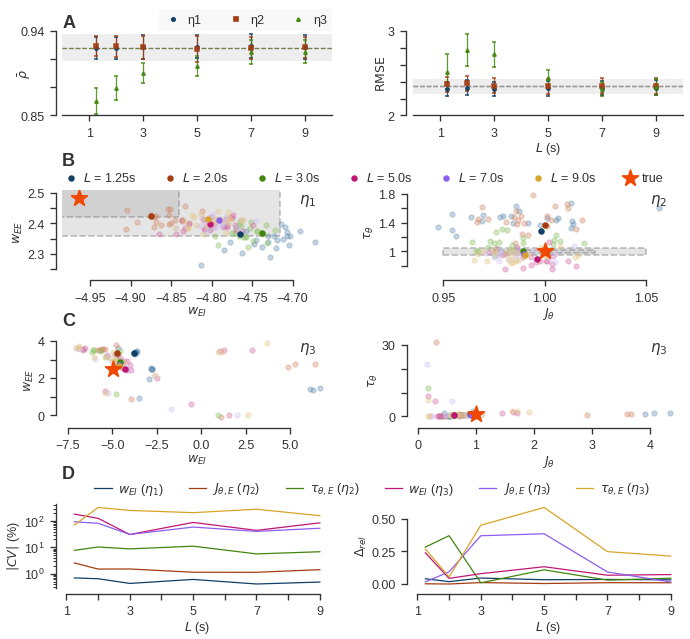

In [25]:
fig = plt.figure(figsize=(textwidth, 1.5*figheight))

gs = GridSpec(6,2) # Odd rows for spacing
#gs.set_height_ratios((.8,0.45,1.5,1.5,0.65,1.6))
gs.set_height_ratios((1.2,-.75,1.2,1.2,-0.65,1.2))
gs.set_width_ratios((1,1))
gs.update(hspace=1.6, wspace=0.3, top=.95)

relα = 1.
markers = {'η1': 'o', 'η2': 's', 'η3': '^'}
proxyartists = {}

with plt.style.context({'axes.labelpad': 1}):

    axρ = plt.subplot(gs[0,0])
    axrms = plt.subplot(gs[0,1])
    #axρbar = axρ.twinx()
    axρbar = axρ
    #axrmsebar = axrms.twinx()
    for η, sims in test_sims.items():
        marker = markers[η]
        # per-trial stats
        c = colours[0]  # Unused at the moment
        lbl = "$"+η[0]+"_{"+η[1]+"}$"
        _rms = lib.AxAttrs(
                {L: {'μ':np.mean(tuple(v.values())), 'σ':np.std(tuple(v.values()),axis=0).mean()}
                    for L,v in sims.rms.items()})
        #ρ = {L: np.mean([c[0] for c in sims.corr[L]]) for L in datalens + ['true'] if L in sims.corr}
        ρ = {L: {'μ':np.mean(tuple(sims.corr[L].values())),
                             'σ':np.std(tuple(sims.corr[L].values()),axis=0).mean()}
                         for L in datalens + ['true'] if L in sims.corr}
        #lib.sim_correlation_plot(axρ, ρ, xticks=datalens, yticks=[.4, .5, .6], ylim=(0.4, .66), label=lbl)
        lib.sim_rms_plot(axrms, _rms, xticks=datalens, ylim = (2, 3), label=lbl, marker=marker, alpha=0.85)
        
        # trial-averaged stats
        c = colours[int(η[1])-1]
        ρbar = barstats[η].ρ
        rmsebar = barstats[η].rmse
        μρ = lib.AxAttrs({L: np.mean(barstats[η].ρ[L]) for L in ρbar})
        σρ = barstats[η].bootstrap_std['ρ']
        μrmse = lib.AxAttrs({L: np.mean(barstats[η].rmse[L]) for L in rmsebar})
        σrmse = barstats[η].bootstrap_std['rmse']
        
        axρbar.axhline(np.mean(ρbar['true']), color=c, alpha=0.4, linestyle='--')
        axρbar.axhspan(np.clip(μρ.true-σρ.true, 0, np.inf),
                       np.clip(μρ.true+σρ.true, 0, np.inf),
                       facecolor=shadec, zorder=-3)
        axρbar.errorbar(datalens, μρ[datalens], σρ[datalens],
                        marker=marker, color=c, alpha=0.85, linestyle='none')
        proxyartists[η] = mpl.lines.Line2D([0], [0], color=c, marker=marker, linestyle='none')
        #axrmsebar.axhline(np.mean(rmsebar['true']), color=c, alpha=0.4, linestyle='--')
        #axrmsebar.axhspan(np.clip(μrmse.true-σrmse.true, -1, 1),
        #                  np.clip(μrmse.true+σrmse.true, -1, 1),
        #                  facecolor=shadec, zorder=-3)
        #axrmsebar.errorbar(datalens, μrmse[datalens], σrmse[datalens],
        #                   marker='D', color=c, alpha=0.6)
        
        #ρbartrue = np.mean(barstats[η].ρ['true'])
        #axρbar.plot(datalens, ρ[datalens], label=lbl)
        
    #axρ.set_yticks([.5, .6])
    #axρ.set_ylim([.5, .6])        
    axρbar.set_ylim(0.85, 0.94)
    axρbar.set_yticks([0.85, 0.88, 0.91, 0.94])
    
    #axrmsebar.set_ylim(0.4, 1.45)
    #axrmsebar.set_yticks([0.4, 0.6, 0.8, 1.0, 1.2])
    
    axρ.legend(handles = list(proxyartists.values()),
               labels  = list(proxyartists),
               ncol=3, loc='lower right', bbox_to_anchor=(1,1), framealpha=0.05,
               facecolor='#888888', borderpad=.4, numpoints=1)
    #axρ.legend(ncol=3, framealpha=0.1, facecolor='#888888', borderpad=.4)
    #axrms.legend(ncol=3, framealpha=0.1, facecolor='#888888', borderpad=.4)
    #ml.plot.add_corner_xlabel(axρ, "$L$ (s)", fontproperties={'size': mpl.rcParams['xtick.labelsize']})
    #axρ.yaxis.set_label_coords(-0.08, 0.5)
    axρ.set_ylabel("ρ")
    axrms.set_ylabel("RMSE  ", labelpad=0)
    #axρ.text(0.7, 0.6, "ρ", va='top', fontdict={'weight': 'bold'})
    #axrms.text(0.7, 2.5, "RMS", va='top', fontdict={'weight': 'bold'})
    axρ.set_xlim(0, 10)
    axrms.set_xlim(0, 10)
    ##axρ.set_ylim(0.47, 0.62)
    #axρ.set_ylim(0.55, 0.67)
    #axrms.set_ylim(2, 3.1)
    axρ.set_xticks([1, 3, 5, 7, 9])
    axrms.set_xticks([1, 3, 5, 7, 9])
    #axρ.set_yticks([.5, .55, .6])
    #axρ.set_yticklabels(['0.5', '', '0.6'])
    #axrms.set_yticks([2, 2.25, 2.5, 2.75, 3])
    #axrms.set_yticklabels(['2', '', '', '', '3'])
    #ml.plot.detach_spines(axρ)
    #ml.plot.detach_spines(axrms)
    ml.plot.subreflabel(axρ, "a", y=1)
    
    # ρ plot
    #c = colours[2]
    axbar = axρbar
    axbar.spines['right'].set_visible(False)
    axbar.spines['left'].set_visible(True)
    axbar.set_ylim(0.85, 0.94)
    axbar.set_yticks([0.85, 0.88, 0.91, 0.94])
    ml.plot.detach_spines(ax=axbar, spines='left')
    axbar.set_yticklabels(["0.85", "", "", "0.94"])
    #axbar.spines['right'].set_ec(c)
    #axbar.yaxis.set_tick_params(color=c)
    axbar.set_ylabel(r"$\bar{ρ}$", labelpad=-8)
    #move_ylabel_down(axbar)
    
    # RMSE plot
    ax = axrms
    #c = colours[0]
    ax.set_yticks([2, 2.2, 2.4, 2.6, 2.8, 3])
    ax.set_yticklabels(["2", "", "", "", "", "3"])
    ax.set_ylabel(r"$\mathsf{RMSE}$")
    #move_ylabel_down(ax)
    #ax.spines['left'].set_ec(c)
    #ax.yaxis.set_tick_params(color=c)
    #ax.yaxis.set_ticklabels(ax.yaxis.get_ticklabels(), color=c)
    
    #axbar = axrmsebar
    #c = colours[2]
    #axbar.spines['left'].set_visible(False)
    #axbar.spines['right'].set_visible(True)
    #axbar.set_ylim(0.4, 1.45)
    #axbar.set_yticks([0.4, 0.6, 0.8, 1.0, 1.2])
    #ml.plot.detach_spines(ax=axbar, spines='right')
    #axbar.set_yticklabels(["0.4", "", "", "", "1.2"], color=c)
    #axbar.spines['right'].set_ec(c)
    #axbar.yaxis.set_tick_params(color=c)
    #axbar.set_ylabel(r"$\overline{\mathsf{RMSE}}$", labelpad=-3, color=c)
    #move_ylabel_down(axbar)
    

    ax = plt.subplot(gs[2,0])
    xvar = ('w', 1)
    yvar = ('w', 0)
    lib.scatter_fitresults(ax, test_sims['η1'].fitcolls, xvar=xvar, yvar=yvar,
                           relalpha=relα)
    ax.text(.94, .97, "$η_1$", ha='right', va='top', transform=ax.transAxes)
    ax.legend(loc='lower left', bbox_to_anchor=(0,1.07), ncol=7, labelspacing=1.5, handletextpad=0.25)
    yticks = [2.25, 2.3, 2.35, 2.4, 2.45, 2.5]
    ax.set_yticks(yticks)
    ax.set_yticklabels([yticks[i] if i%2==1 else "" for i in range(len(yticks))])
    ax.set_xlabel(test_sims['η1'].get_varstring(xvar))
    ax.set_ylabel(test_sims['η1'].get_varstring(yvar))
    #ml.plot.add_corner_ylabel(ax, get_varname('η1', ('w', 0)))
    ml.plot.subreflabel(ax, "b", y=1.25)
    ml.plot.detach_spines(ax)
    ax.spines['bottom'].set_bounds(-4.95, -4.70)
    

    ax = plt.subplot(gs[3,0])
    #xvar = ('w', 2)  # Use same vars as plot above
    #yvar = ('w', 0)
    #xvar = ('w', 1)
    fitcolls = test_sims['η3'].fitcolls
    lib.scatter_fitresults(ax, fitcolls, xvar=xvar, yvar=yvar, relalpha=relα)
    ax.text(.94, .97, "$η_3$", ha='right', va='top', transform=ax.transAxes)
    ax.get_legend().set_visible(False)
    #xlim = ax.get_xlim(); ax.set_xlim(xlim[0], xlim[-1] + 5)
    yticks = [0, 1, 2, 3, 4]
    ax.set_yticks(yticks)
    #ax.set_yticklabels([yticks[i] if i%2==1 else "" for i in range(len(yticks))])
    ax.set_yticklabels(['0', '', '2', '', '4'])
    ax.set_xlabel(test_sims['η3'].get_varstring(xvar))
    ax.set_ylabel(test_sims['η3'].get_varstring(yvar))
    ml.plot.subreflabel(ax, "c", y=1.1)
    ml.plot.detach_spines(ax)
    ax.spines['bottom'].set_bounds(-7.5, 5.0)


    ax = plt.subplot(gs[2,1])
    xvar = 'J_θ'
    yvar = 'τ_θ'
    lib.scatter_fitresults(ax, test_sims['η2'].fitcolls, xvar=xvar, yvar=yvar,
                           relalpha=relα)
    ax.text(0.94, 0.97, "$η_2$", ha='right', va='top', transform=ax.transAxes)
    ax.get_legend().set_visible(False)
    ax.set_xticks([0.95, 1, 1.05])
    yticks = [.8, 1, 1.2, 1.4, 1.6, 1.8]
    ax.set_yticks(yticks)
    ax.set_yticklabels([yticks[i] if i%2==1 else "" for i in range(len(yticks))])
    ml.plot.detach_spines(ax)

    ax = plt.subplot(gs[3,1])
    #xvar = ('w', 2)  # Use same vars as plot above
    #yvar = ('w', 0)
    fitcolls = test_sims['η3'].fitcolls
    lib.scatter_fitresults(ax, fitcolls, xvar=xvar, yvar=yvar, relalpha=relα)
    ax.text(.94, .97, "$η_3$", ha='right', va='top', transform=ax.transAxes)
    ax.get_legend().set_visible(False)
    #xlim = ax.get_xlim(); ax.set_xlim(xlim[0], xlim[-1] + 5)
    yticks = [0, 10, 20, 30]
    ax.set_yticks(yticks)
    #ax.set_yticklabels([yticks[i] if i%2==1 else "" for i in range(len(yticks))])
    ax.set_yticklabels(['0', '', '', '30'])
    ml.plot.detach_spines(ax)
    #ax.set_xlabel(test_sims['η3'].get_varstring(xvar))
    #ax.set_ylabel(test_sims['η3'].get_varstring(yvar))

    ax = plt.subplot(gs[5,0])
    rows = {'η1': [('w', 1)],
            'η2': [('J_θ', 0), ('τ_θ', 0)],
            'η3': [('w', 1), ('J_θ', 0), ('τ_θ', 0)]}
    statlbls = ['CV']
    with plt.style.context({}):#'legend.framealpha': 0.1, 'legend.facecolor': '#888888',
                                #'legend.borderpad': 0.4}):
        ax, ax2 = lib.plot_fitstats(ax=ax, η=['η1', 'η2', 'η3'], datalens=datalens, param_subsets=param_subsets,
                                    test_sims=test_sims, rows=rows, statlbls=statlbls)
    ax.get_legend().set_visible(False)
    ml.plot.set_legend_linewidth(1.5, ax)
    xticks = list(range(1, 10))
    ax.set_xticks(xticks)
    ax.set_xticklabels([xticks[i] if i%2==0 else "" for i in range(len(xticks))])
    #ax.set_yticks([0, 3, 6, 9, 12])
    #ax.set_yticklabels([0, '', 6, '', 12])
    #ax2.set_yticks([0, .1, .2, .3, .4])
    #ax2.set_yticklabels([0, '', .2, '', .4])
    #ax2.set_ylabel('$\\Delta_{rel}$', labelpad=2)
    #ax.set_xlim(.85, 9.15)
    #ax2.spines['right'].set_position(('outward', 0))
    #ax2.set_yticklabels(['', .1, '', .3, ''])
    ml.plot.subreflabel(ax, "d", y=1.25)
    ax.set_yscale('log')
    ax.set_yticks([1e0, 1e1, 1e2])
    ax.spines['left'].set_bounds(*ax.get_ylim())
    ml.plot.detach_spines(ax, spines=['bottom'])
    
    
    ax = plt.subplot(gs[5,1])
    rows = {'η1': [('w', 1)],
            'η2': [('J_θ', 0), ('τ_θ', 0)],
            'η3': [('w', 1), ('J_θ', 0), ('τ_θ', 0)]}
    statlbls = ['Δrel']
    with plt.style.context({}):#'legend.framealpha': 0.1, 'legend.facecolor': '#888888',
                               #'legend.borderpad': 0.4}):
        ax, ax2 = lib.plot_fitstats(ax=ax, η=['η1', 'η2', 'η3'], datalens=datalens, param_subsets=param_subsets,
                                    test_sims=test_sims, rows=rows, statlbls=statlbls,
                                    legend_kwargs={'loc': 'lower right',
                                                   'bbox_to_anchor': (0.9,1.0),
                                                   'ncol': 6})
        ax.set_xticks([1,2,3,4,5,6,7,8,9])
        ax.set_xticklabels(["1","","3","","5","","7","","9"])
        ml.plot.detach_spines(ax, spines=['bottom'])

gs.update(bottom=0.08, left=0.09, right=0.99)
        
assert(outputname == 'Fig4')
if savefig:
    plt.savefig("figures/" + os.path.splitext(outputname)[0] + '.' + saveext.strip('.'))

Output the data for $|CV|$ and $Δ_{rel}$ as latex tables.

In [21]:
table_fitstats_CV_latex = lib.fitstat_table('CV', param_subsets.keys(), datalens, test_sims, param_subsets,
                                      latex=True)
table_fitstats_CV_latex

'\\begin{tabular}{llrrrrrr}\n\\hline\n      & L &   1.25 &   2.00 &    3.00 &    5.00 &    7.00 &    9.00 \\\\\nSubset & Parameter &        &        &         &         &         &         \\\\\n\\hline\n$η_1$ & $w_{EE}$ &   1.33 &   0.83 &    0.96 &    0.70 &    0.61 &    0.82 \\\\\n      & $w_{EI}$ &   0.69 &   0.64 &    0.42 &    0.60 &    0.40 &    0.48 \\\\\n      & $w_{IE}$ &   1.38 &   1.37 &    1.53 &    1.77 &    1.90 &    1.36 \\\\\n      & $w_{II}$ &   0.40 &   0.46 &    0.58 &    0.39 &    0.61 &    0.65 \\\\\n$η_2$ & $J_{θ,E}$ &   2.56 &   1.49 &    1.50 &    1.13 &    1.13 &    1.42 \\\\\n      & $τ_{θ,E}$ &   7.70 &  10.33 &    8.75 &   11.11 &    5.64 &    6.82 \\\\\n$η_3$ & $J_{θ,E}$ &  94.03 &  82.51 &   30.99 &   59.25 &   40.58 &   53.40 \\\\\n      & $\\Delta u_E$ &  14.98 &  19.16 &    6.11 &   11.37 &    7.58 &    8.84 \\\\\n      & $\\Delta u_I$ &  32.84 &  30.33 &   13.28 &   41.22 &   21.86 &   34.30 \\\\\n      & $c_{E}$ &  83.08 &  65.81 &   37.16 &   39.42 

In [22]:
table_fitstats_Drel_latex = lib.fitstat_table('Δrel', param_subsets.keys(), datalens, test_sims, param_subsets,
                                        latex=True)
table_fitstats_Drel_latex

'\\begin{tabular}{llrrrrrr}\n\\hline\n      & L &  1.25 &  2.00 &  3.00 &  5.00 &  7.00 &  9.00 \\\\\nSubset & Parameter &       &       &       &       &       &       \\\\\n\\hline\n$η_1$ & $w_{EE}$ & 0.047 & 0.023 & 0.045 & 0.034 & 0.029 & 0.027 \\\\\n      & $w_{EI}$ & 0.040 & 0.018 & 0.046 & 0.033 & 0.035 & 0.032 \\\\\n      & $w_{IE}$ & 0.013 & 0.038 & 0.000 & 0.001 & 0.005 & 0.024 \\\\\n      & $w_{II}$ & 0.018 & 0.005 & 0.022 & 0.018 & 0.012 & 0.005 \\\\\n$η_2$ & $J_{θ,E}$ & 0.002 & 0.000 & 0.011 & 0.004 & 0.010 & 0.009 \\\\\n      & $τ_{θ,E}$ & 0.283 & 0.370 & 0.009 & 0.108 & 0.030 & 0.045 \\\\\n$η_3$ & $J_{θ,E}$ & 0.016 & 0.094 & 0.369 & 0.385 & 0.092 & 0.016 \\\\\n      & $\\Delta u_E$ & 0.215 & 0.182 & 0.090 & 0.086 & 0.092 & 0.052 \\\\\n      & $\\Delta u_I$ & 0.520 & 0.338 & 0.466 & 0.302 & 0.129 & 0.058 \\\\\n      & $c_{E}$ & 0.420 & 0.376 & 0.469 & 0.382 & 0.239 & 0.160 \\\\\n      & $c_{I}$ & 2.825 & 0.006 & 0.133 & 0.142 & 0.128 & 0.161 \\\\\n      & $w_{EE}$ & 0.345